In [2]:
%run ../../lib/basic-import.ipynb
%run ../../lib/plot-functions.ipynb

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import termtables as tt
import os.path

#pip install termtables

In [ ]:
add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
def pd_plot_lap_save_corr_new():
    for participant in participant_files:
        ID = participant[:-4]  
        #for now, we are only looking at 50338
        add_df_338 = add_df[ID]
        # 15
        #Sjekker der alle verdiene ikke er NaNs. 
        #Gjør det samme som din tidligere funksjon, bare med timestamp som index i betraktning :P.
        add_df_338 = add_df_338[~add_df_338.isnull().all(1)]

        lapRange_df_li = []
        
        # Think this is better. Find where lap changes value by 1 and make a list of the index.
        lapTimestamp_li = list(add_df_338.index[add_df_338['lap'].diff() == 1])

        # Find +30s, -15 from lap increase, and store all rows
        timedelta_30s = pd.Timedelta("00:00:30")
        timedelta_15s = pd.Timedelta("00:00:15")
        for i in range(len(lapTimestamp_li)):
            startRow = add_df_338.index.get_loc(lapTimestamp_li[i]-timedelta_15s)
            endRow = add_df_338.index.get_loc(lapTimestamp_li[i]+timedelta_30s)
            lapRange_df_li.append(add_df_338.iloc[startRow:endRow])

        # Create plot for every stop
        for i in range(len(lapTimestamp_li)):
            fig, ax = plt.subplots()

            trans = ax.get_xaxis_transform()

            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax4 = ax.twinx()
            ax5 = ax.twinx()
            ax6 = ax.twinx()

            rightPosition = 1.00
            leftPosition = -0.20

            rightPosition = ax_modification(ax2,'right', rightPosition)
            rightPosition = ax_modification(ax3,'right', rightPosition)
            leftPosition = ax_modification(ax4,'left', leftPosition)
            rightPosition = ax_modification(ax5,'right', rightPosition)
            leftPosition = ax_modification(ax6,'left', leftPosition)
            
            plot_title = "lap {}: -15,+30 pd {}".format(i,ID)

            lapRange_df_li[i]['accumulated_power'].plot(ax=ax, color='red',legend=False, title=plot_title)
            lapRange_df_li[i]['speed'].plot(ax=ax2, color='blue',legend=False)
            lapRange_df_li[i]['power'].plot(ax=ax3, color='green',legend=False)
            lapRange_df_li[i]['altitude'].plot(ax=ax4, color='orange',legend=False)
            lapRange_df_li[i]['distance'].plot(ax=ax5, color='lightcoral',legend=False)
            lapRange_df_li[i]['heart_rate'].plot(ax=ax6, color='purple',legend=False)    
            ax.axvline((lapTimestamp_li[i]), color='black', linestyle='--', lw=2)
            ax.text((lapTimestamp_li[i]),.5,(lapTimestamp_li[i]),transform=trans)

            #dårlige runtime, trenge sikkert ikkje sjekka kver einaste value.
            #bør tenka på ein bedre måte
            check_ylim(ax,lapRange_df_li[i],'accumulated_power')
            check_ylim(ax2,lapRange_df_li[i],'speed')
            check_ylim(ax3,lapRange_df_li[i],'power')
            check_ylim(ax4,lapRange_df_li[i],'altitude')
            check_ylim(ax5,lapRange_df_li[i],'distance')

            ax_style(ax,'Accumulated Power','red')
            ax_style(ax2,'Speed','blue')
            ax_style(ax3,'Power','green')
            ax_style(ax4,'Altitude','orange')
            ax_style(ax5,'Distance','lightcoral')
            ax_style(ax6,'Heartrate','purple')
            
            #bbox_inches makes it possible to see all y axis in image.
            #all the y axis didnt show pdf when incrementing rightposition and leftposition.
            #however think we need to resize it to fit in the pdf.
            fig.savefig("lap{}pd{}.png".format(i,ID), format="png", bbox_inches='tight')

        #getting original/suggested/final timestamp and original distance
        timestamp_original = lapTimestamp_li
        timestamp_suggested = []
        timestamp_final = []
        distance_original = []

        for i in range(len(lapRange_df_li)):
            temp = lapRange_df_li[i][((lapRange_df_li[i]['speed'] == 0) & (lapRange_df_li[i]['power'] == 0)) | ((lapRange_df_li[i]['speed'] == 0) & (lapRange_df_li[i]['power'].isnull().all()))]
            timestamp_suggested.append(temp.iloc[0].name)
            timestamp_final.append(temp.iloc[0].name.date())
            distance_original.append(lapRange_df_li[i].loc[lapTimestamp_li[i], 'distance'])
            
        #allVals is the values over in one array.
        allVals = []
        for i in range(len(timestamp_original)):
            allVals.append([timestamp_original[i], timestamp_suggested[i], timestamp_final[i], distance_original[i]])

        #table which is shown. might change the names.
        # removed lap for now, should add back later
        headerTable = ['original timestamp','suggested timestamp','corrected timestamp','original distance']
        print(tt.to_string(allVals, header=headerTable)) #need help, looks ugly

        #tableDF, used in csv.
        dataTableDF = [headerTable] + allVals
        tableDF = pd.DataFrame(dataTableDF[1:],columns=dataTableDF[0]).set_index('original timestamp')
        tableDF.to_csv('correlation_{}'.format(ID)+'.csv')

        #basicly lager data/ID folders hvis ikke eksisterer. Hvis data/id/csv fil eksisterer, slett og flytt den nye der. Samme med bilder. Ser sykt ut då hahah.
        if not os.path.exists('../data/{}'.format(ID)):
            os.makedirs('../data/{}'.format(ID))
        if os.path.exists('../data/{}/correlation_{}.csv'.format(ID,ID)):
            os.remove('../data/{}/correlation_{}.csv'.format(ID,ID))
        os.rename('./correlation_{}.csv'.format(ID), '../data/{}/correlation_{}.csv'.format(ID,ID))
        for i in range(len(lapTimestamp_li)):
            if os.path.exists('../data/{}/lap{}pd{}.png'.format(ID,i,ID)):
                os.remove('../data/{}/lap{}pd{}.png'.format(ID,i,ID))
            os.rename('./lap{}pd{}.png'.format(i,ID), '../data/{}/lap{}pd{}.png'.format(ID,i,ID))

pd_plot_lap_save_corr_new()

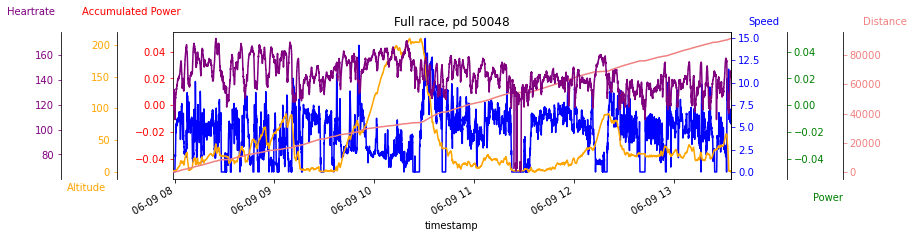

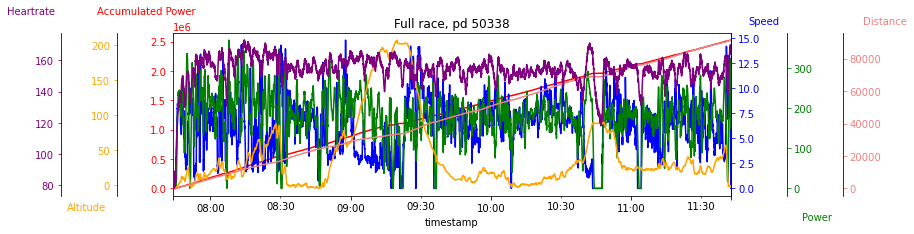

In [9]:
def pd_plot_full():
    add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
    for participant in participant_files:
        ID = participant[:-4]  
        #for now, we are only looking at 50338
        add_df_338 = add_df[ID]
        # 15
        #Sjekker der alle verdiene ikke er NaNs. 
        #Gjør det samme som din tidligere funksjon, bare med timestamp som index i betraktning :P.
        add_df_338 = add_df_338[~add_df_338.isnull().all(1)]
    
        rightPosition = 1.00
        leftPosition = -0.10

        fig, ax = plt.subplots()

        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()

        ax.autoscale(enable=True, axis='x', tight=True)
        ax2.autoscale(enable=True, axis='x', tight=True)
        ax3.autoscale(enable=True, axis='x', tight=True)
        ax4.autoscale(enable=True, axis='x', tight=True)
        ax5.autoscale(enable=True, axis='x', tight=True)
        ax6.autoscale(enable=True, axis='x', tight=True)

        rightPosition = ax_modification(ax2,'right', rightPosition) - 0.1
        rightPosition = ax_modification(ax3,'right', rightPosition) - 0.1
        leftPosition = ax_modification(ax4,'left', leftPosition) + 0.1
        rightPosition = ax_modification(ax5,'right', rightPosition) - 0.1
        leftPosition = ax_modification(ax6,'left', leftPosition) + 0.1

        add_df_338['accumulated_power'].plot(ax=ax, color='red',legend=False, title="Full race, pd {}".format(ID), figsize=(10,3))
        add_df_338['speed'].plot(ax=ax2, color='blue',legend=False)
        add_df_338['power'].rolling(window=45).mean().plot(ax=ax3, color='green',legend=False)
        add_df_338['altitude'].plot(ax=ax4, color='orange',legend=False)
        add_df_338['distance'].plot(ax=ax5, color='lightcoral',legend=False)
        add_df_338['heart_rate'].plot(ax=ax6, color='purple',legend=False)

        trans = ax.get_xaxis_transform()

        ax_style(ax,'Accumulated Power','red')
        ax_style(ax2,'Speed','blue')
        ax_style(ax3,'Power','green')
        ax_style(ax4,'Altitude','orange')
        ax_style(ax5,'Distance','lightcoral')
        ax_style(ax6,'Heartrate','purple')

        fig.savefig("fullracepd{}.png".format(ID), format="png", bbox_inches='tight')

        if not os.path.exists('../data/{}'.format(ID)):
            os.makedirs('../data/{}'.format(ID))
        if os.path.exists('../data/{}/fullracepd{}.png'.format(ID,ID)):
            os.remove('../data/{}/fullracepd{}.png'.format(ID,ID))
        os.rename('./fullracepd{}.png'.format(ID), '../data/{}/fullracepd{}.png'.format(ID,ID))

pd_plot_full()

In [ ]:

#def pd_plot_lap_save_corr():
#    add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
#    ID = '50338'
#    rightPosition = 1.00
#    leftPosition = -0.10

#    fig, ax = plt.subplots()
#    fig.subplots_adjust(right=2)

#    ax2 = ax.twinx()
#    ax3 = ax.twinx()
#    ax4 = ax.twinx()
#    ax5 = ax.twinx()
#    ax6 = ax.twinx()

#    rightPosition = ax_modification(ax2,'right', rightPosition)
#    rightPosition = ax_modification(ax3,'right', rightPosition)
#    leftPosition = ax_modification(ax4,'left', leftPosition)
#    rightPosition = ax_modification(ax5,'right', rightPosition)
#    leftPosition = ax_modification(ax6,'left', leftPosition)

#    lapDates = add_df[ID].index[add_df[ID]['lap'].diff()==1]
    #create new pd lap_df. Contains only +30, -15 sec laps, 1 ekstra for nans.
    #lap_df, gir en ny dataframe. Denne inneholder de tre lap_dfs dataframe.
#    lap_dfs = get_lapdf(add_df, ID, 15, 32, lapDates)
#    lap_df = pd.concat(lap_dfs)
#    lap_df.index = map(lambda x: str(x)[-8:], lap_df.index)

#    lap_df['accumulated_power'].plot(ax=ax, color='red',legend=False, title="all laps -15,+30 pd 50338")
#    lap_df['speed'].plot(ax=ax2, color='blue',legend=False)
#    lap_df['power'].plot(ax=ax3, color='green',legend=False)
#    lap_df['altitude'].plot(ax=ax4, color='orange',legend=False)
#    lap_df['distance'].plot(ax=ax5, color='lightcoral',legend=False)
#    lap_df['heart_rate'].plot(ax=ax6, color='purple',legend=False)

#    ax_style(ax,'Accumulated Power','red')
#    ax_style(ax2,'Speed','blue')
#    ax_style(ax3,'Power','green')
#    ax_style(ax4,'Altitude','orange')
#    ax_style(ax5,'Distance','lightcoral')
#    ax_style(ax6,'Heartrate','purple')

    #getting correlation values, now values and changeable values.
#    nowVals = get_now_val(lapDates, ID, add_df)
#    corrVals = get_corr_val(lap_dfs)
#    changVals = [date.date() for date in lapDates]

    #allVals is the values over in one array.
#    allVals = []
#    for i in range(len(corrVals)):
#        allVals.append([changVals[i]] + [corrVals[i]] + nowVals[i])

    #table which is shown. might change the names.
#    headerTable = ['timestamp correlation changeable','timestamp correlation suggestion','timestamp now','lap','distance']
#    print(tt.to_string(allVals, header=headerTable))

    #tableDF, used in csv.
#    dataTableDF = [headerTable] + allVals
#    tableDF = pd.DataFrame(dataTableDF[1:],columns=dataTableDF[0]).set_index('timestamp correlation changeable')
#   tableDF.to_csv('correlation_{}'.format(ID)+'.csv')


#pd_plot_lap_save_corr()


In [ ]:
add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
def pd_plot_corr():
    for participant in participant_files:
        ID = participant[:-4]
        add_df_338_new = add_df[ID]
        add_df_338_new = add_df_338_new[~add_df_338_new.isnull().all(1)]

        corrDF = pd.read_csv('../data/{}/correlation_{}.csv'.format(ID,ID)).set_index("corrected timestamp")
        corrTS = get_corrTS(corrDF)

        lapRange_df_li = []
        timedelta_30s = pd.Timedelta("00:00:30")
        timedelta_15s = pd.Timedelta("00:00:15")
        for i in range(len(corrTS)):
            startRow = add_df_338_new.index.get_loc(corrTS[i]-timedelta_15s)
            endRow = add_df_338_new.index.get_loc(corrTS[i]+timedelta_30s)
            lapRange_df_li.append(add_df_338_new.iloc[startRow:endRow])

        for i in range(len(lapRange_df_li)):
            rightPosition = 1.00
            leftPosition = -0.20

            fig, ax = plt.subplots()

            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax4 = ax.twinx()
            ax5 = ax.twinx()
            ax6 = ax.twinx()

            rightPosition = ax_modification(ax2,'right', rightPosition)
            rightPosition = ax_modification(ax3,'right', rightPosition)
            leftPosition = ax_modification(ax4,'left', leftPosition)
            rightPosition = ax_modification(ax5,'right', rightPosition)
            leftPosition = ax_modification(ax6,'left', leftPosition)

            lapRange_df_li[i]['accumulated_power'].plot(ax=ax, color='red',legend=False, title="corr lap {} -15,+30 pd {}".format(i, ID))
            lapRange_df_li[i]['speed'].plot(ax=ax2, color='blue',legend=False)
            lapRange_df_li[i]['power'].plot(ax=ax3, color='green',legend=False)
            lapRange_df_li[i]['altitude'].plot(ax=ax4, color='orange',legend=False)
            lapRange_df_li[i]['distance'].plot(ax=ax5, color='lightcoral',legend=False)
            lapRange_df_li[i]['heart_rate'].plot(ax=ax6, color='purple',legend=False)

            trans = ax.get_xaxis_transform()
            ax.axvline((corrTS[i]), color='black', linestyle='--', lw=2)
            ax.text((corrTS[i]),.5,(corrTS[i]),transform=trans)

            check_ylim(ax,lapRange_df_li[i],'accumulated_power')
            check_ylim(ax2,lapRange_df_li[i],'speed')
            check_ylim(ax3,lapRange_df_li[i],'power')
            check_ylim(ax4,lapRange_df_li[i],'altitude')
            check_ylim(ax5,lapRange_df_li[i],'distance')

            ax_style(ax,'Accumulated Power','red')
            ax_style(ax2,'Speed','blue')
            ax_style(ax3,'Power','green')
            ax_style(ax4,'Altitude','orange')
            ax_style(ax5,'Distance','lightcoral')
            ax_style(ax6,'Heartrate','purple')

pd_plot_corr()